The electric company I use sends weekly emails about your power usage and how much you spent for the prior week.
<br>I noticed my bill was getting higher which is fairly normal due to summer. The red flag was it is significantly higher than last year. 
<br>So I decided to look into my data and use it as an excuse to get better at Matplotlib.
<br><br>
Note that my data is through 5/24/2022

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from jupyterthemes import jtplot
import matplotlib.pyplot as plt
from datetime import datetime

jtplot.style(theme='monokai', context='talk', fscale=1.4, ticks=True, grid=False, figsize=(6, 4.5), gridlines='--')

In [2]:
data1 = pd.read_csv('2020-08-22_to_2021-08-21.csv')
data2 = pd.read_csv('2021-08-21_to_2022-05-25.csv')
df = pd.concat([data1, data2], ignore_index=True, sort=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61536 entries, 0 to 61535
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        61536 non-null  object 
 1   DATE        61536 non-null  object 
 2   START TIME  61536 non-null  object 
 3   END TIME    61536 non-null  object 
 4   USAGE       61536 non-null  float64
 5   UNITS       61536 non-null  object 
 6   COST        61536 non-null  object 
 7   NOTES       336 non-null    object 
dtypes: float64(1), object(7)
memory usage: 3.8+ MB


In [4]:
# Lots of column making, not all are used in this repo.

df.columns = df.columns.str.lower()
df['month'] = pd.to_datetime(df['date']).dt.strftime('%B')
df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')
df['date-time'] = df['date'] + " " + df['start time']
df['date-time'].apply(pd.to_datetime, format='%m/%d/%Y %H:%M')
df['date-time'] = pd.to_datetime(df['date-time'])
df['hour'] = df['date-time'].dt.hour
df['12hour'] = pd.to_datetime(df['date-time']).dt.strftime('%I:%M %p')
df['chart-date'] = df['date-time'].dt.strftime('%Y-%m-%d')
df['year-month'] = df['year'] + '-' + df['month']
df['month-num'] = pd.DatetimeIndex(df['date-time']).month
df['cost'] = df['cost'].str.replace('$','')
df['cost'] = df['cost'].astype(float)
df['week-num'] = df['date-time'].dt.week
df['day-num'] = df['date-time'].dt.day_of_week
df['day-name'] = df['date-time'].dt.day_name()
df['day-name'] = df['day-name'].str.strip()


df.sort_values(['date-time'], ascending=[True], inplace = True)
df.reset_index(drop=True)

df_totals = df.groupby(['year-month', 'month', 'month-num', 'year'])[['usage','cost']].sum().reset_index()

<ipython-input-4-158d77c02505>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['cost'] = df['cost'].str.replace('$','')
<ipython-input-4-158d77c02505>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week-num'] = df['date-time'].dt.week


In [5]:
df.head()

,type,date,start time,end time,usage,units,cost,notes,month,year,date-time,hour,12hour,chart-date,year-month,month-num,week-num,day-num,day-name
0,Electric usage,8/22/2020,00:00,00:14,0.56,kWh,0.04,NaN,August,2020,2020-08-22 00:00:00,0,12:00 AM,2020-08-22,2020-August,8,34,5,Saturday
1,Electric usage,8/22/2020,00:15,00:29,0.55,kWh,0.04,NaN,August,2020,2020-08-22 00:15:00,0,12:15 AM,2020-08-22,2020-August,8,34,5,Saturday
2,Electric usage,8/22/2020,00:30,00:44,0.48,kWh,0.04,NaN,August,2020,2020-08-22 00:30:00,0,12:30 AM,2020-08-22,2020-August,8,34,5,Saturday
3,Electric usage,8/22/2020,00:45,00:59,0.58,kWh,0.04,NaN,August,2020,2020-08-22 00:45:00,0,12:45 AM,2020-08-22,2020-August,8,34,5,Saturday
4,Electric usage,8/22/2020,01:00,01:14,0.65,kWh,0.05,NaN,August,2020,2020-08-22 01:00:00,1,01:00 AM,2020-08-22,2020-August,8,34,5,Saturday


Let's start with just a quick year overview.
<br> A quick note on the week numbers can be found here: https://stackoverflow.com/questions/44372048/python-pandas-timestamp-week-returns-52-for-first-day-of-year

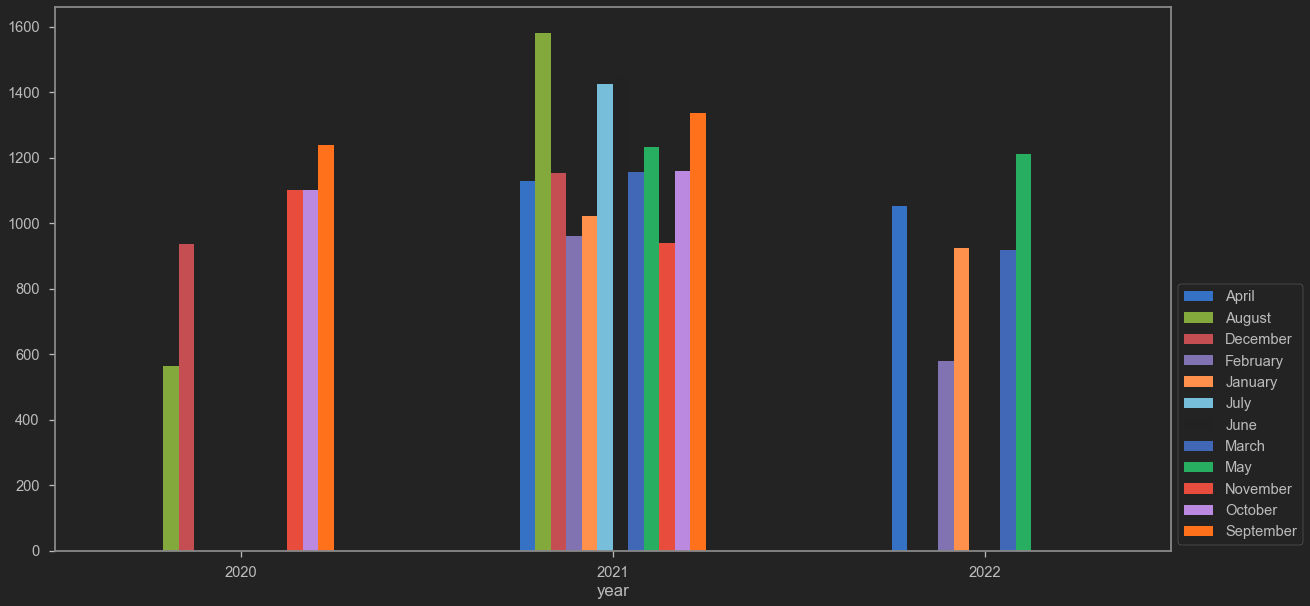

In [6]:
ax = pd.crosstab(df['year'], df['month'], values = df['usage'], aggfunc='sum', margins = False).plot.bar(rot = 0, figsize = (20,10))
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.25))

The chart is half useful and half not useful. There is no title, the colors are pretty awful, and the months are not in the correct order. While you can see the breakdown by year it is still hard to compare a month from this year to last year.
<br><br>
If I was asked to create this (literal exact) chart in a business enviornment I would at least add the average usage as a line across the chart, adjust June to not use the color black, and add a title. One quick piece of advice for anyone who wants to create or creates data visualization for work is color choice will matter. I encourage my coworkers to adjust their color choice to take into account colorblindness.
<br><br>
I will make a slightly better version of this chart below. What your questions your stakeholders want answers to will drive what / how you make the chart though. Since I am my own stakeholder I will make them how I feel I best get value.
<br><br>
I will quickly declare my colorblind colors for use in charts and a months list to rearrange any chart axis.

In [7]:
cb_colors = ('#004949','#009292','#ff6db6','#ffb6db',
 '#490092','#006ddb','#b66dff','#6db6ff','#b6dbff',
 '#920000','#924900','#db6d00','#24ff24','#ffff6d')

months = ('January', 'February', 'March', 'April',
          'May', 'June', 'July', 'August',
          'September', 'October', 'November', 'December')

days = ('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday')

Average KWH use is 1098.65


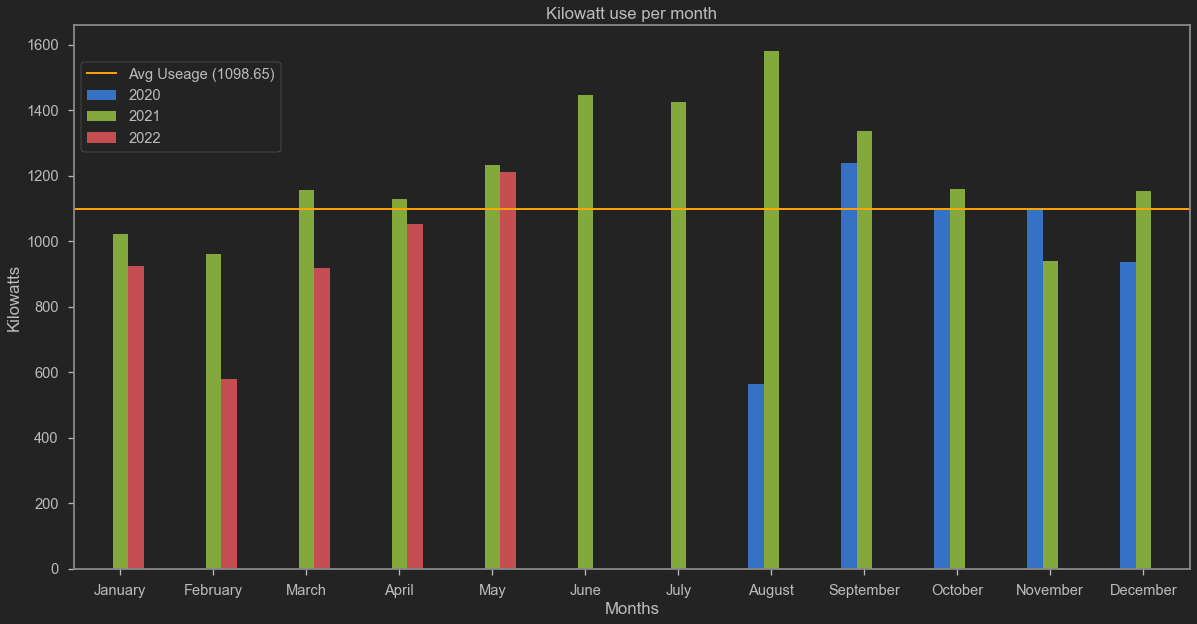

In [8]:
chart_title = 'Kilowatt use per month'
avg_usage_ct = pd.crosstab(df['month'], df['year'], values = df['usage'], aggfunc='sum', margins = False).reindex(months)
num  = df['usage'].sum()
denom = df['year-month'].drop_duplicates().value_counts().sum()
avgusage =  round((num / denom),2)

# I only need three colors so I will directly call three to differentiate them.
ax = avg_usage_ct.plot.bar(rot = 0, figsize = (20,10), title = chart_title)
plt.axhline(avgusage, color = 'orange', label = (f'Avg Useage ({avgusage})'))

ax.set_xlabel("Months")
ax.set_ylabel("Kilowatts")

ax.legend(loc = 'center left', bbox_to_anchor=(0, 0.85))

print(f'Average KWH use is {avgusage}')

So for 11 months I am above my average power usage. Mostly in the summer months which makes sense since I do live in Texas.
<br>
Let's look at a cost breakdown using the same chart then move on to a new one chart type looking over the same data.

Average cost is $103.48


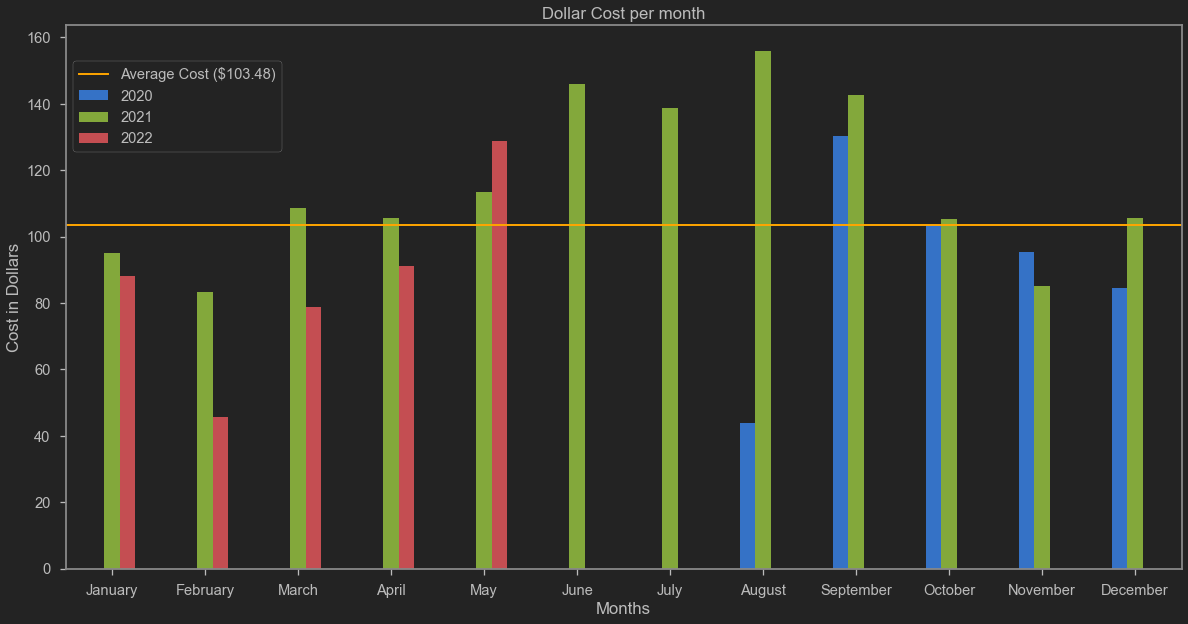

In [9]:
chart_title = 'Dollar Cost per month'
avg_cost_ct = pd.crosstab(df['month'], df['year'], values = df['cost'], aggfunc='sum', margins = False).reindex(months)
num  = df['cost'].sum()
denom = df['year-month'].drop_duplicates().value_counts().sum()
avgcost =  round((num / denom),2)

# I only need three colors so I will directly call three to differentiate them.
ax = avg_cost_ct.plot.bar(rot = 0, figsize = (20,10), title = chart_title)
plt.axhline(avgcost, color = 'orange', label = (f'Average Cost (${avgcost})'))

ax.set_xlabel("Months")
ax.set_ylabel("Cost in Dollars")

ax.legend(loc = 'center left', bbox_to_anchor=(0, 0.85))

print(f'Average cost is ${avgcost}')

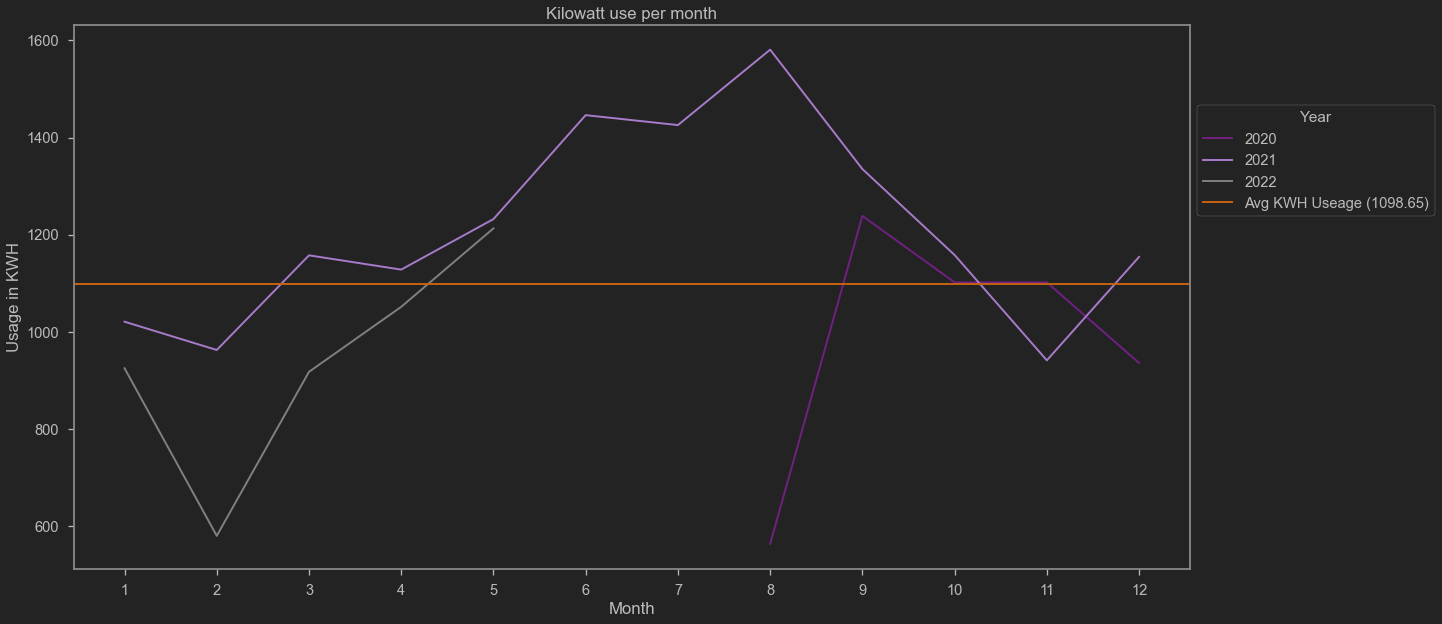

Average KWH use is 1098.65


<Figure size 561.6x421.2 with 0 Axes>

In [10]:
# Taco Bell color scheme for fun. Although I had to change the black to grey.
colors = ['#702082', '#A77BCA', '#808080']
chart_title = 'Kilowatt use per month'

xtick_count = len(df_totals['month-num'].drop_duplicates())

i = 0
xtick_range = []

while i < xtick_count:
    i = i + 1
    xtick_range.append(i)

avg_cost_ct = pd.crosstab(df_totals['month-num'], df_totals['year'], values = df_totals['usage'], aggfunc='sum', margins = False)
num  = df_totals['usage'].sum()
denom = df_totals['year-month'].drop_duplicates().value_counts().sum()
avgusage =  round((num / denom),2)

ax = avg_cost_ct.plot(rot = .5, title = chart_title, figsize = (20,10), color = colors)

plt.axhline(avgusage, color = '#C46210', label = (f'Avg KWH Useage ({avgusage})'))
#ax.set(facecolor = "white")
start, end = ax.get_xlim()
ax.set_xlabel("Month")
ax.set_ylabel("Usage in KWH")

plt.xticks(xtick_range)
ax.legend(loc = 'center left', bbox_to_anchor=(1, .75), title = 'Year')

fig = plt.gcf()
plt.show()
plt.draw()

print(f'Average KWH use is {avgusage}')
#fig.savefig('Avg Cost by Year.png', dpi=100)

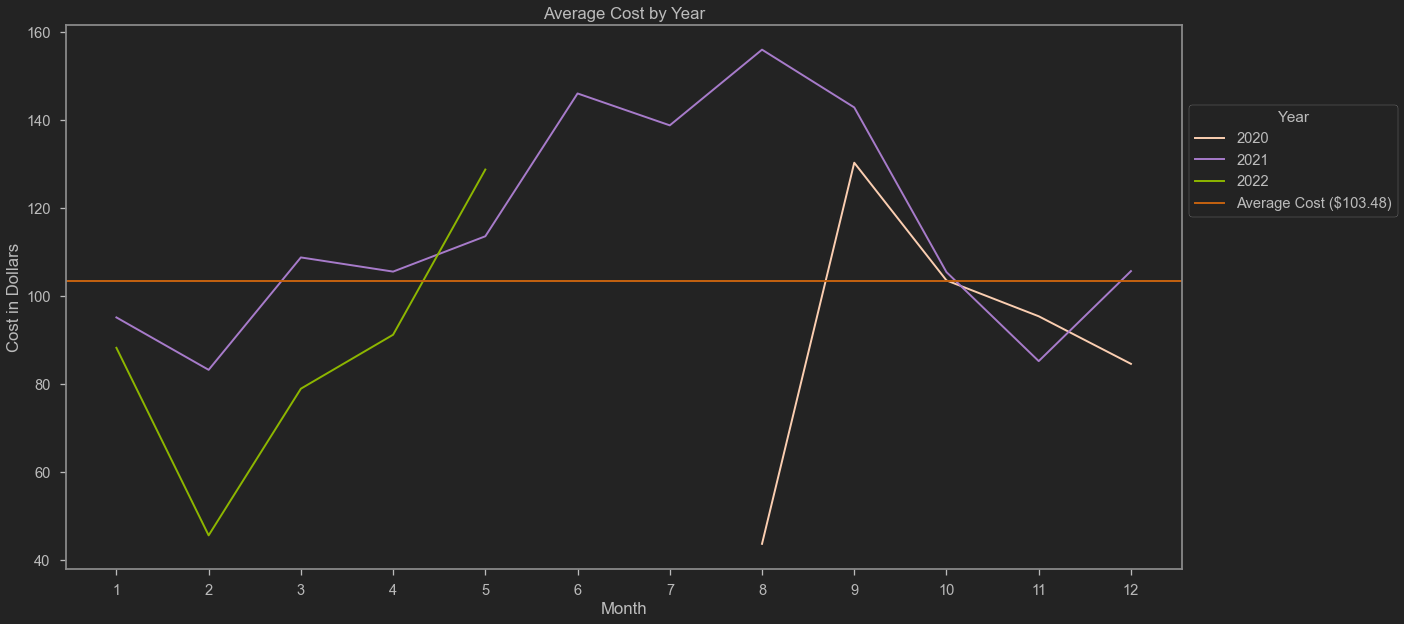

Average cost is $103.48


<Figure size 561.6x421.2 with 0 Axes>

In [11]:
colors = ['#FBCEB1', '#A77BCA', '#8DB600']
chart_title = 'Average Cost by Year'

xtick_count = len(df_totals['month-num'].drop_duplicates())

i = 0
xtick_range = []

while i < xtick_count:
    i = i + 1
    xtick_range.append(i)

avg_cost_ct = pd.crosstab(df_totals['month-num'], df_totals['year'], values = df_totals['cost'], aggfunc='sum', margins = False)
num  = df_totals['cost'].sum()
denom = df_totals['year-month'].drop_duplicates().value_counts().sum()
avgcost =  round((num / denom),2)

ax = avg_cost_ct.plot(rot = .5, title = chart_title, figsize = (20,10), color = colors)

plt.axhline(avgcost, color = '#C46210', label = (f'Average Cost (${avgcost})'))
#ax.set(facecolor = "white")
start, end = ax.get_xlim()
ax.set_xlabel("Month")
ax.set_ylabel("Cost in Dollars")

plt.xticks(xtick_range)
ax.legend(loc = 'center left', bbox_to_anchor=(1, .75), title = 'Year')

fig = plt.gcf()
plt.show()
plt.draw()
#fig.savefig('Avg Cost by Year.png', dpi=100)

print(f'Average cost is ${avgcost}')

Let's do a quick look at week over week. I suspect this will not have much value due to the sheer amount of weeks in the year.

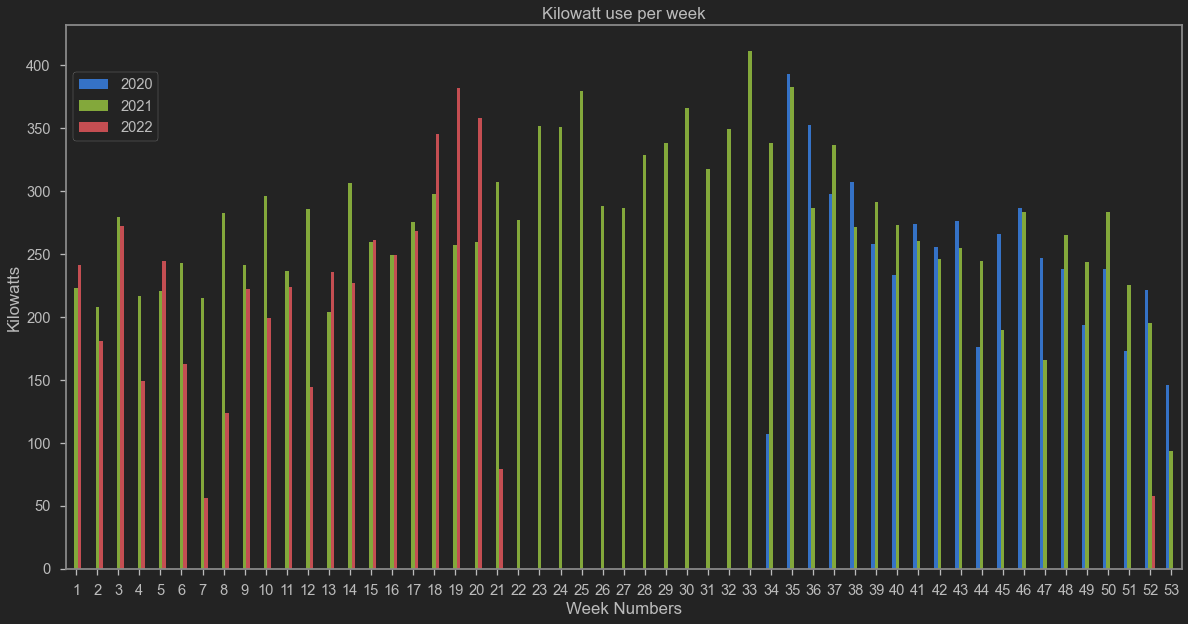

In [12]:
chart_title = 'Kilowatt use per week'
avg_usage_ct = pd.crosstab(df['week-num'], df['year'], values = df['usage'], aggfunc='sum', margins = False)

ax = avg_usage_ct.plot.bar(rot = 0, figsize = (20,10), title = chart_title)

ax.set_xlabel("Week Numbers")
ax.set_ylabel("Kilowatts")

ax.legend(loc = 'center left', bbox_to_anchor=(0, 0.85))


It is not the best chart to look at but it is visually useful. Look at the weeks of the 18th through the 20th. These are in the month of May and those weeks are significantly higher than last year.

<br><br>How does my daily useage compare this year vs last year in May?


Average KWH use is 222.28


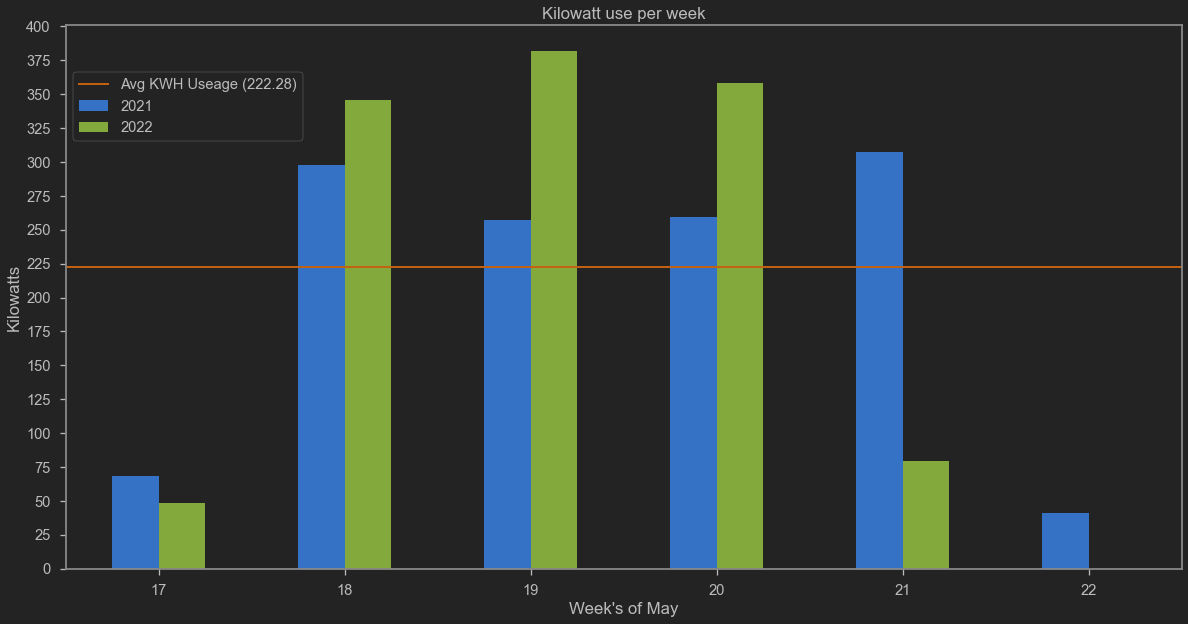

In [13]:
# Make a quick dataframe for only the weeks of may
may_df = df.loc[(df['month'] == 'May')]
chart_title = 'Kilowatt use per week'
avg_usage_ct = pd.crosstab(may_df['week-num'], may_df['year'], values = may_df['usage'], aggfunc='sum', margins = False)

ax = avg_usage_ct.plot.bar(rot = 0, figsize = (20,10), title = chart_title)

num  = may_df['usage'].sum()
denom = may_df.groupby(['year-month', 'week-num']).sum().drop_duplicates().value_counts().sum()
avgusage =  round((num / denom),2)

plt.axhline(avgusage, color = '#C46210', label = (f'Avg KWH Useage ({avgusage})'))

plt.yticks(np.arange(0, 401, 25)) 
ax.set_xlabel("Week's of May")
ax.set_ylabel("Kilowatts")

ax.legend(loc = 'center left', bbox_to_anchor=(0, 0.85))

print(f'Average KWH use is {avgusage}')

So starting the week of the 18th until the week of the 20th my usage went significantly higher.

Average Cost per week is 22.03


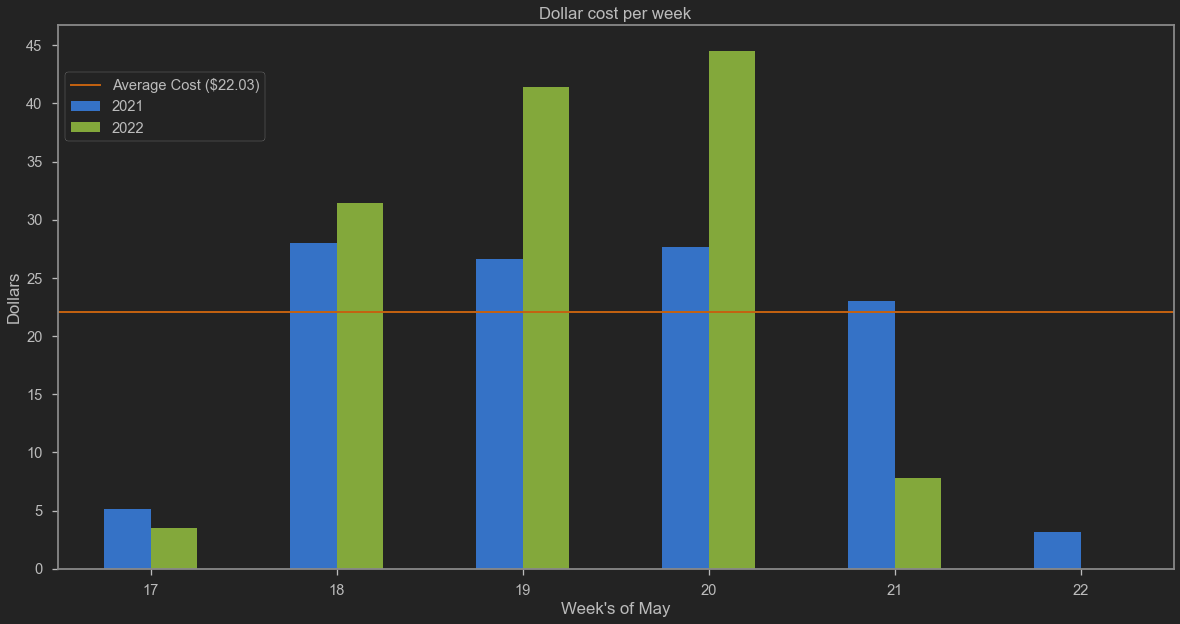

In [14]:
# Make a quick dataframe for only the weeks of may
may_df = df.loc[(df['month'] == 'May')]
chart_title = 'Dollar cost per week'
avg_cost_ct = pd.crosstab(may_df['week-num'], may_df['year'], values = may_df['cost'], aggfunc='sum', margins = False)

ax = avg_cost_ct.plot.bar(rot = 0, figsize = (20,10), title = chart_title)

num  = may_df['cost'].sum()
denom = may_df.groupby(['year-month', 'week-num']).sum().drop_duplicates().value_counts().sum()
avgcost =  round((num / denom),2)
max_cost = round(may_df.groupby(['year', 'week-num'])['cost'].sum().drop_duplicates().max(),2)

plt.axhline(avgcost, color = '#C46210', label = (f'Average Cost (${avgcost})'))

plt.yticks(np.arange(0, max_cost+1, 5)) 
ax.set_xlabel("Week's of May")
ax.set_ylabel("Dollars")

ax.legend(loc = 'center left', bbox_to_anchor=(0, 0.85))


print(f'Average Cost per week is {avgcost}')

Average Cost per day is 17.31


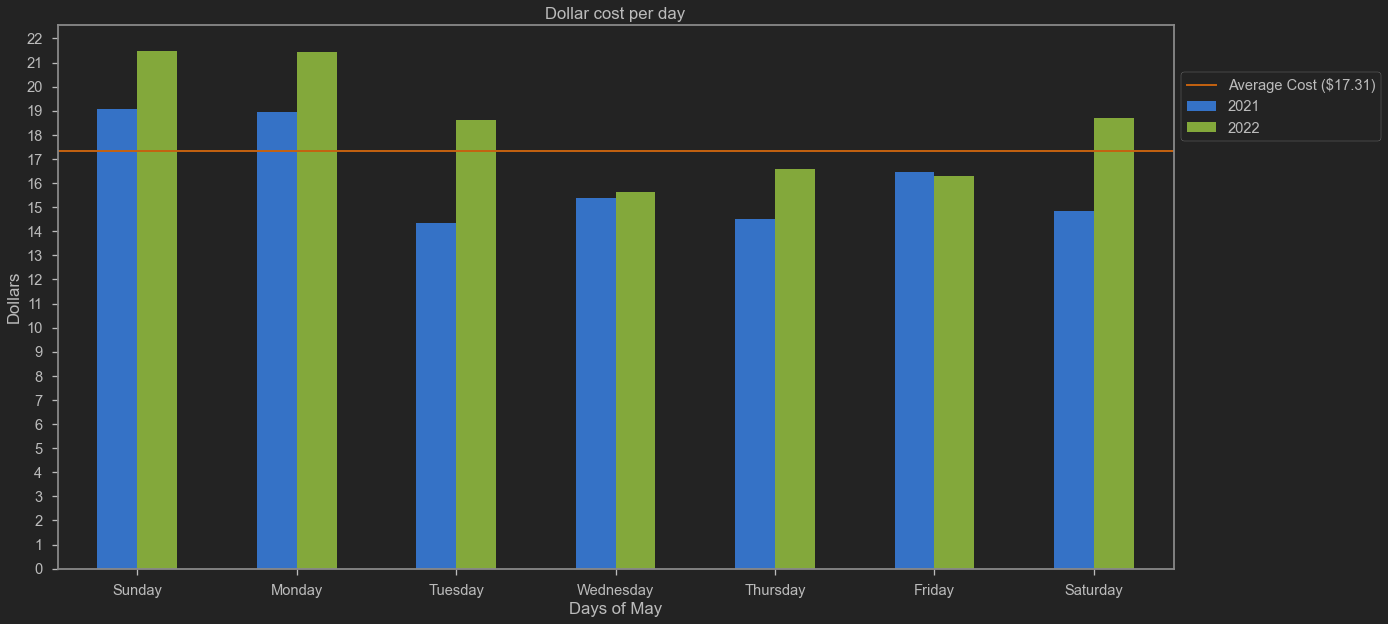

In [15]:
# Make a quick dataframe for only the weeks of may
chart_title = 'Dollar cost per day'
avg_cost_ct = pd.crosstab(may_df['day-name'], may_df['year'], values = may_df['cost'], aggfunc='sum', margins = False).reindex(days)

ax = avg_cost_ct.plot.bar(rot = 0, figsize = (20,10), title = chart_title)

avgcost =  round(may_df.groupby(['year', 'day-name'])['cost'].sum().drop_duplicates().mean(),2)
max_cost = round(may_df.groupby(['year', 'day-name'])['cost'].sum().drop_duplicates().max(),2)

plt.axhline(avgcost, color = '#C46210', label = (f'Average Cost (${avgcost})'))

plt.yticks(np.arange(0, max_cost+1, 1)) 
ax.set_xlabel("Days of May")
ax.set_ylabel("Dollars")

ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.85))


print(f'Average Cost per day is {avgcost}')

So it seems Saturday, Sunday, and Monday are my worst days for May. On my own I will look into the breakdown by hour but I do not want to release that information.
<br><br>
Overall this was fun and I am more comfortable with Matplotlib afterwards. Plus I can always refer to this notebook if I need to remember how to do something.